<table align="left">
  <td>
    <a href="https://is.gd/IznnUd" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Regresión Logistica para predecir - Admisiones a Universidades de Ranking Mundial

This dataset is created for prediction of Graduate Admissions from an Indian perspective

[Dataset Predicción de Admisión](https://www.kaggle.com/mohansacharya/graduate-admissions?select=Admission_Predict.csv)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Obtener los datos de un dataset y almacenarlos en un dataframe de pandas. 

In [19]:
admision_df = pd.read_csv("/content/drive/MyDrive/data/Admission_Predict_Ver1_1.csv", sep=",")
# remover espacios en blanco en las cabeceras
admision_df.rename(columns=lambda x: x.strip(), inplace=True) 

# Eliminar la columnas 'Serial No.' no hace parte del analisis
admision_df.drop(columns={'Serial No.'}, inplace=True)
admision_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


### Descripción de los atributos

- GRE Scores: Prueba de aptitud estandarizada para programas de posgrado que mide el pensamiento abstracto en áreas como la comprensión lectora, la escritura y las matemáticas.
- TOEFL Scores: Prueba de Ingles
- University Rating: Valoración de la Universidad 
- SOP: Carta de Intenciones
- LOR: Carta de Recomendación
- CGPA: Promedio del Pregrado
- Research Experience: Experiencia en Investigación 
- **Chance of Admit** (TARGET): Posibilidad de admisión

### Presentar la cabecera de datos. De esta manera es posible identificar observar los 5 primeros datos del dataset.


In [20]:
admision_df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [21]:
admision_df.columns[1:]

Index(['TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research',
       'Chance of Admit'],
      dtype='object')

### En el siguiente mapa de calor se ve cual es la correlación existente entre todos los valores del dataset con la probabilidad de ser admitido en la universidad. 

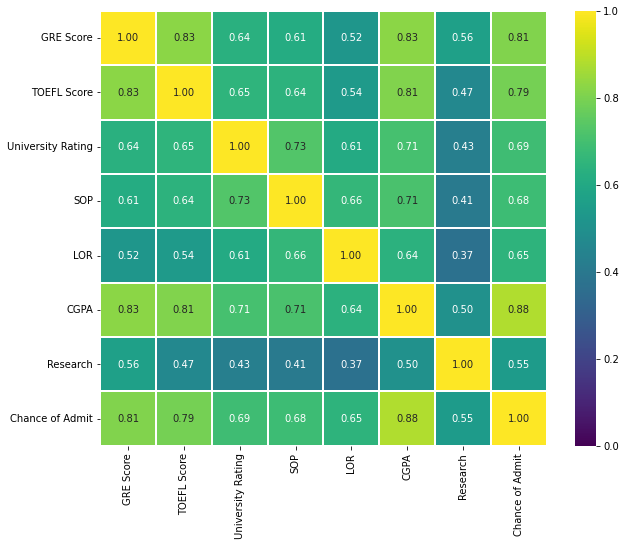

In [22]:
# Mostrar la correlación entre todos los datos utilizando sns.heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(admision_df.corr(), ax=ax, annot=True, linewidths=1, fmt='.2f',
            cmap="viridis", vmin=0, vmax=1)
plt.show()

In [23]:
admision_df.corr()['Chance of Admit'].round(1)

GRE Score            0.8
TOEFL Score          0.8
University Rating    0.7
SOP                  0.7
LOR                  0.6
CGPA                 0.9
Research             0.5
Chance of Admit      1.0
Name: Chance of Admit, dtype: float64

### **Actividad 1**. Basandose en el mapa de calor eliminar las características que presentan una correlación menor al $70\text{%}$ con la probabilidad de ser admitido.


In [24]:
#---Introducir Codigo ---
admision_df.drop(columns={'LOR', 'Research'}, inplace=True)
admision_df.head()

,GRE Score,TOEFL Score,University Rating,SOP,CGPA,Chance of Admit
0,337,118,4,4.5,9.65,0.92
1,324,107,4,4.0,8.87,0.76
2,316,104,3,3.0,8.00,0.72
3,322,110,3,3.5,8.67,0.80
4,314,103,2,2.0,8.21,0.65


### Se crea una copia del dataframe procesado. 

In [25]:
df_procesado = admision_df.copy()
df_procesado.head()


,GRE Score,TOEFL Score,University Rating,SOP,CGPA,Chance of Admit
0,337,118,4,4.5,9.65,0.92
1,324,107,4,4.0,8.87,0.76
2,316,104,3,3.0,8.00,0.72
3,322,110,3,3.5,8.67,0.80
4,314,103,2,2.0,8.21,0.65


In [26]:
# Muestra las dimensiones del dataframe procesado
df_procesado.shape

(500, 6)

# Implementación del algoritmo de Machine Learning

### Se creara el target, el cual es seleccionado utilizando el valor medio de la probabilidad de ser admitido. El valor de media de dicha característica indica una alta probabilidad de ser seleccionado en un programa de pregrado. 

In [27]:
df_procesado['Chance of Admit'].median()

0.72

In [28]:
# Crear los targets, se crea un vector en donde se asigna 1 a los valores mayores a la media de la probabilidad de ser admitido y 0 a los menores. 
targets = np.where(df_procesado['Chance of Admit'] >= df_procesado['Chance of Admit'].median(), 1, 0)
targets.shape

(500,)

### **Actividad 2.** Agregar una columna nueva al dataset con el target, se puede llamar a la columna 'Prob of Acceptance' crear una copia del mismo dataset y almacenarla en una nueva variable y eliminar la columna 'Chance of Admit'

In [29]:
# --- Introducir el codigo Aqui ---
df_procesado['Prob of Acceptance'] = targets
df_targets = df_procesado.copy()
df_targets = df_targets.drop(['Chance of Admit'], axis=1)
df_targets.head()

,GRE Score,TOEFL Score,University Rating,SOP,CGPA,Prob of Acceptance
0,337,118,4,4.5,9.65,1
1,324,107,4,4.0,8.87,1
2,316,104,3,3.0,8.00,1
3,322,110,3,3.5,8.67,1
4,314,103,2,2.0,8.21,0


### Se realiza la selección para los datos de entrada de la regresión. 

In [30]:
from sklearn import preprocessing
inputs = df_targets.iloc[:, :-1]
#Estandarización de los datos https://scikit-learn.org/stable/modules/preprocessing.html
scaler = preprocessing.StandardScaler().fit(inputs)
inputs=scaler.transform(inputs);
inputs = pd.DataFrame(inputs, columns = ['GRE Score',	'TOEFL Score',	'University Rating',	'SOP',	'CGPA'])

print(inputs)

     GRE Score  TOEFL Score  University Rating       SOP      CGPA
0     1.819238     1.778865           0.775582  1.137360  1.776806
1     0.667148    -0.031601           0.775582  0.632315  0.485859
2    -0.041830    -0.525364          -0.099793 -0.377773 -0.954043
3     0.489904     0.462163          -0.099793  0.127271  0.154847
4    -0.219074    -0.689952          -0.975168 -1.387862 -0.606480
..         ...          ...                ...       ...       ...
495   1.376126     0.132987           1.650957  1.137360  0.734118
496   1.819238     1.614278           1.650957  1.642404  2.140919
497   1.198882     2.108041           1.650957  1.137360  1.627851
498  -0.396319    -0.689952           0.775582  0.632315 -0.242367
499   0.933015     0.955926           0.775582  1.137360  0.767220

[500 rows x 5 columns]


### **Actividad 3.** Utilizar la función de **Split the data into train & test sets**, asignar una relación de 80%-20% entre train y test. 

In [31]:
# ---Introducir codigo Aqui ---
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=.2, shuffle=True, random_state=20)

In [32]:
# Displaying the shape of the train and test datasets and targets
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 5) (400,)
(100, 5) (100,)


### **Actividad 4.** Crear y entrenar el modelo de regresión logistica, aplicando la regularización del tipo L2, solver = 'liblinear'.

In [42]:
#---Introducir Codigo Aqui ----
# Crear modelo de regresión logistica
modelo = LogisticRegression(C=0.5)
# Fit the data to the model
modelo.fit(x_train, y_train)

LogisticRegression(C=0.5)

### **Actividad 5.** Evaluar el Comportamiento del modelo, realizar variaciones en el valor de la regularización y registrar los valores que presenten una mejora en el modelo. 

In [43]:
#x_test = scaler.transform(x_test)
y_pred = modelo.predict(x_test)

score_train = modelo.score(x_train, y_train)
score_test = modelo.score(x_test, y_test)

print("score_train: " + str(score_train))
print("score_test: " + str(score_test) + "\n")


score_train: 0.88
score_test: 0.88



## Creando Tabla con resumen de resultados


In [44]:
feature_name = inputs.columns.values
summary_table = pd.DataFrame(columns=['Feature Name'], data=feature_name)
summary_table['Coefficient'] = np.transpose(modelo.coef_)
summary_table.head()

,Feature Name,Coefficient
0,GRE Score,1.284674
1,TOEFL Score,0.494884
2,University Rating,0.121118
3,SOP,0.631303
4,CGPA,1.171624


# Preguntas y Actividades. 

**Comprobar las siguientes preguntas**

1. Utilizando el optimizador liblinear y un valor de penalización diferente al definido, mejoraría el rendimiento del modelo? 

2. Modificando el nivel de exigencia para las características que se utilizan para entrenar el modelo, se lograría mejorar los resultados en las predicciónes?

3. Eliminando la característica que tiene un menor peso en el resultado inicial (University Rating), se obtendría un mejor rendimiento?